In [135]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
import matplotlib.pyplot as plt

In [136]:
#Import data
shrine_players = pd.read_parquet('data/shrine_bowl_players.parquet', engine='fastparquet')
shrine_players.rename(columns={'gsis_player_id': 'college_gsis_id'}, inplace=True)
shrine_players['college_gsis_id'] = shrine_players['college_gsis_id'].astype(int)
# Save as CSV for easier viewing
shrine_players.to_csv('data/shrine_bowl_players.csv', index=False)

college_stats = pd.read_csv('data/shrine_bowl_players_college_stats.csv')
nfl_stats = pd.read_csv('data/shrine_bowl_players_nfl_rookie_stats.csv')
sos_stats = pd.read_csv('data/sos_data.csv')
team_offense = pd.read_csv('data/CFB_TeamOff_2017-2024_via_sportsReference.csv')
combine_data = pd.read_csv('data/combine_data.csv')

print(shrine_players.shape, college_stats.shape, nfl_stats.shape, sos_stats.shape)

(338, 33) (1732, 38) (245, 43) (1181, 7)


In [137]:
shrine_players.head()

,college_gsis_id,first_name,last_name,football_name,weight,hand_size,last_twenty_of_forty_yd_dash,first_ten_of_forty_yd_dash,standing_broad_jump,three_cone,...,draft_round,draft_pick,draft_overall_selection,hometown,hometown_state,hometown_country,recruiting_stars,team_code,team_name,conference
0,350698,Dwight,McGlothern,Dwight,189.0,8.5,1.8699999,1.55,111.0,7.23,...,None,None,None,Houston,TX,US,4,ARUN,Arkansas Razorbacks,Southeastern Conference
1,336849,Hunter,Nourzad,Hunter,319.0,10.75,None,None,None,None,...,5,24,160,Marietta,GA,US,None,PAST,Penn State Nittany Lions,Big Ten Conference
2,362959,Jaden,Shirden,Jaden,189.0,9.25,1.8799999,1.56,117.0,None,...,None,None,None,West Haven,CT,US,None,NJMO,Monmouth Hawks,Colonial Athletic Association
3,324852,David,Ugwoegbu,David,243.0,10.25,1.97,1.75,116.0,7.56,...,None,None,None,Katy,TX,US,3,TXHO,Houston Cougars,Big Twelve Conference
4,304792,Ernest,Perry,E.J.,208.0,9.0,1.99,1.58,123.0,6.85,...,None,None,None,Andover,MA,US,3,RIBR,Brown Bears,Ivy League


In [138]:
college_stats.head()

,college_gsis_id,position,player_name,season,team,school_code,passing_attempts,passing_completions,passing_yards,passing_completion_percentage,...,kickreturns_no,kickreturns_touchdowns,kickreturns_yards,puntreturns_avg,puntreturns_long,puntreturns_no,puntreturns_td,puntreturns_yds,total_fumbles,total_fumbles_lost
0,158332,DT,Garrett Marino,2017,UAB,ALBI,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,158332,DT,Garrett Marino,2018,UAB,ALBI,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,158332,DT,Garrett Marino,2019,UAB,ALBI,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,172387,DS,Austin Lee,2017,BYU,UTBY,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,172387,DS,Austin Lee,2018,BYU,UTBY,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [139]:
nfl_stats.head()

,college_gsis_id,rookie_season,player_name,position,draft_season,draft_round,draft_overall_selection,scrambles,qb_pressures,qb_pressure_to_sack_rate,...,rushing_yards,rushing_touchdowns,receiving_targets,receiving_receptions,receiving_yards,receiving_yards_per_route_run,receiving_touchdowns,receiving_yards_after_catch,defense_interceptions,defense_pass_breakups
0,196601,2020,Khalil Davis,DT,2020,6.0,194.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,305707,2024,Dallas Gant,IB,2024,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,316846,2023,Moro Ojomo,DT,2023,7.0,249.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,196251,2020,Alex Highsmith,DE,2020,3.0,102.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
4,282907,2022,Samori Toure,WR,2022,7.0,258.0,NaN,NaN,NaN,...,NaN,NaN,10.0,5.0,82.0,1.108108,1.0,11.0,NaN,NaN


In [140]:
sos_stats.head()

,Rank,Team,Rating,Hi,Lo,Last,Year
0,1,Indiana,17.3,1,68,2,2025
1,2,Ohio St,16.0,2,18,14,2025
2,3,Alabama,15.5,1,21,1,2025
3,4,Oregon,15.4,1,71,3,2025
4,5,Texas,13.8,1,20,8,2025


In [141]:
# Get standerdized SOS values
sos_mean = sos_stats['Rating'].mean()
sos_std = sos_stats['Rating'].std()
sos_stats['Rating'] = (sos_stats['Rating'] - sos_mean) / sos_std
sos_stats.head()

,Rank,Team,Rating,Hi,Lo,Last,Year
0,1,Indiana,2.244937,1,68,2,2025
1,2,Ohio St,2.083466,2,18,14,2025
2,3,Alabama,2.021361,1,21,1,2025
3,4,Oregon,2.008941,1,71,3,2025
4,5,Texas,1.810207,1,20,8,2025


In [142]:
print(college_stats.columns)
print(college_stats['position'].unique())
print((college_stats['player_name'].nunique()))

Index(['college_gsis_id', 'position', 'player_name', 'season', 'team',
       'school_code', 'passing_attempts', 'passing_completions',
       'passing_yards', 'passing_completion_percentage', 'passing_touchdowns',
       'passing_interceptions', 'rushing_attempts', 'rushing_yards',
       'rushing_touchdowns', 'receiving_receptions', 'receiving_touchdowns',
       'receiving_yards', 'defense_pass_breakups', 'defense_qb_hurries',
       'defense_sacks', 'defense_solo_tackles', 'defense_total_tackles',
       'defense_tackles_for_loss', 'defense_interceptions',
       'defense_touchdowns', 'kickreturns_avg', 'kickreturns_long',
       'kickreturns_no', 'kickreturns_touchdowns', 'kickreturns_yards',
       'puntreturns_avg', 'puntreturns_long', 'puntreturns_no',
       'puntreturns_td', 'puntreturns_yds', 'total_fumbles',
       'total_fumbles_lost'],
      dtype='object')
['DT' 'DS' 'WR' 'DC' 'QB' 'DE' 'RB' 'OB' 'IB' 'OG' 'TE' 'OT' 'OC' 'FB']
465


In [143]:
#Get stat shares
college_stats['rec_yds_share'] = np.nan
college_stats['rec_td_share'] = np.nan
college_stats['rec_cmp_share'] = np.nan
college_stats['rush_yds_share'] = np.nan
college_stats['rush_td_share'] = np.nan
college_stats['rush_atmp_share'] = np.nan
college_stats['opp_sos_rating'] = np.nan

for index, row in college_stats.iterrows():
    team = row['team']
    year = row['season']
    team_totals = team_offense[((team_offense['School'] == team) & (team_offense['Year'] == year))][['tot_pass_yds','tot_pass_td','tot_pass_cmp','tot_rush_yds','tot_rush_td','tot_rush_atmp']]
    team_sos = sos_stats[(sos_stats['Team'] == team) & (sos_stats['Year'] == year)]['Rating']

    if not team_totals.empty:
        team_totals = team_totals.iloc[0]
        college_stats.loc[index, 'rec_yds_share'] = row['receiving_yards'] / team_totals['tot_pass_yds']
        college_stats.loc[index, 'rec_td_share'] = row['receiving_touchdowns'] / team_totals['tot_pass_td']
        college_stats.loc[index, 'rec_cmp_share'] = row['receiving_receptions'] / team_totals['tot_pass_cmp']
        college_stats.loc[index, 'rush_yds_share'] = row['rushing_yards'] / team_totals['tot_rush_yds']
        college_stats.loc[index, 'rush_td_share'] = row['rushing_touchdowns'] / team_totals['tot_rush_td']
        college_stats.loc[index, 'rush_atmp_share'] = row['rushing_attempts'] / team_totals['tot_rush_atmp']
        college_stats.loc[index, 'opp_sos_rating'] = team_sos.values[0] if not team_sos.empty else np.nan

In [144]:

college_stats.head()

,college_gsis_id,position,player_name,season,team,school_code,passing_attempts,passing_completions,passing_yards,passing_completion_percentage,...,puntreturns_yds,total_fumbles,total_fumbles_lost,rec_yds_share,rec_td_share,rec_cmp_share,rush_yds_share,rush_td_share,rush_atmp_share,opp_sos_rating
0,158332,DT,Garrett Marino,2017,UAB,ALBI,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-1.717319
1,158332,DT,Garrett Marino,2018,UAB,ALBI,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,-0.003145,0.0,0.005263,0.001773,0.0,0.004839,-0.872700
2,158332,DT,Garrett Marino,2019,UAB,ALBI,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-1.344693
3,172387,DS,Austin Lee,2017,BYU,UTBY,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,172387,DS,Austin Lee,2018,BYU,UTBY,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
college_totals = (
    college_stats
    .groupby("college_gsis_id", as_index=False)
    .agg(
        team=('team', 'first'),
        max_season=('season', 'max'),
        position=('position', 'first'),
        receiving_receptions=('receiving_receptions', 'sum'),
        receiving_yards=('receiving_yards', 'sum'),
        receiving_touchdowns=('receiving_touchdowns', 'sum'),
        rushing_attempts=('rushing_attempts', 'sum'),
        rushing_yards=('rushing_yards', 'sum'),
        rushing_touchdowns=('rushing_touchdowns', 'sum'),
        passing_completions=('passing_completions', 'sum'),
        passing_yards=('passing_yards', 'sum'),
        passing_touchdowns=('passing_touchdowns', 'sum'),
        passing_interceptions=('passing_interceptions', 'sum'),
        seasons_played=('position', 'size'),
        avg_rec_yds_share=('rec_yds_share', 'max'),
        avg_rec_td_share=('rec_td_share', 'max'),
        avg_rec_cmp_share=('rec_cmp_share', 'max'),
        avg_rush_yds_share=('rush_yds_share', 'max'),
        avg_rush_td_share=('rush_td_share', 'max'),
        avg_rush_atmp_share=('rush_atmp_share', 'max'),
        avg_opp_sos_rating=('opp_sos_rating', 'mean')
    )
)
print(college_totals.shape)
college_totals.head()

(465, 22)


,college_gsis_id,team,max_season,position,receiving_receptions,receiving_yards,receiving_touchdowns,rushing_attempts,rushing_yards,rushing_touchdowns,...,passing_touchdowns,passing_interceptions,seasons_played,avg_rec_yds_share,avg_rec_td_share,avg_rec_cmp_share,avg_rush_yds_share,avg_rush_td_share,avg_rush_atmp_share,avg_opp_sos_rating
0,158332,UAB,2019,DT,1.0,-9.0,0.0,3.0,5.0,0.0,...,0.0,0.0,3,-0.003145,0.000000,0.005263,0.001773,0.000000,0.004839,-1.311570
1,172387,BYU,2019,DS,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,172698,Indiana,2019,WR,84.0,1162.0,9.0,0.0,0.0,0.0,...,0.0,0.0,2,0.190692,0.217391,0.132911,NaN,NaN,NaN,0.661277
3,172890,Minnesota,2019,DC,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,0.735802
4,173519,Clemson,2019,QB,0.0,0.0,0.0,328.0,1037.0,14.0,...,30.0,15.0,3,NaN,NaN,NaN,0.243590,0.268293,0.332756,1.226426


In [146]:
college_nfl_merged = pd.merge(college_totals, nfl_stats, on='college_gsis_id', how='left', suffixes=('_college', '_nfl'))
college_nfl_merged.head()

,college_gsis_id,team,max_season,position_college,receiving_receptions_college,receiving_yards_college,receiving_touchdowns_college,rushing_attempts_college,rushing_yards_college,rushing_touchdowns_college,...,rushing_yards_nfl,rushing_touchdowns_nfl,receiving_targets,receiving_receptions_nfl,receiving_yards_nfl,receiving_yards_per_route_run,receiving_touchdowns_nfl,receiving_yards_after_catch,defense_interceptions,defense_pass_breakups
0,158332,UAB,2019,DT,1.0,-9.0,0.0,3.0,5.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,172387,BYU,2019,DS,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,172698,Indiana,2019,WR,84.0,1162.0,9.0,0.0,0.0,0.0,...,NaN,NaN,8.0,3.0,33.0,NaN,NaN,5.0,NaN,NaN
3,172890,Minnesota,2019,DC,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,173519,Clemson,2019,QB,0.0,0.0,0.0,328.0,1037.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [147]:
# A player is considered to have played in the NFL if they have played more than 30 snaps
college_nfl_merged['played_in_nfl'] = college_nfl_merged['total_snaps'].apply(lambda x: 1 if x > 30 else 0)

wr_merged = college_nfl_merged[college_nfl_merged['position_college'] == 'WR']
qb_merged = college_nfl_merged[college_nfl_merged['position_college'] == 'QB']
te_merged = college_nfl_merged[college_nfl_merged['position_college'] == 'TE']
rb_merged = college_nfl_merged[college_nfl_merged['position_college'] == 'RB']

## WR

In [148]:
wr_merged.head()

,college_gsis_id,team,max_season,position_college,receiving_receptions_college,receiving_yards_college,receiving_touchdowns_college,rushing_attempts_college,rushing_yards_college,rushing_touchdowns_college,...,rushing_touchdowns_nfl,receiving_targets,receiving_receptions_nfl,receiving_yards_nfl,receiving_yards_per_route_run,receiving_touchdowns_nfl,receiving_yards_after_catch,defense_interceptions,defense_pass_breakups,played_in_nfl
2,172698,Indiana,2019,WR,84.0,1162.0,9.0,0.0,0.0,0.0,...,NaN,8.0,3.0,33.0,NaN,NaN,5.0,NaN,NaN,1
14,191527,Louisiana,2019,WR,139.0,1989.0,22.0,3.0,30.0,0.0,...,NaN,11.0,5.0,60.0,NaN,NaN,9.0,NaN,NaN,1
22,194682,Missouri,2019,WR,129.0,1755.0,11.0,3.0,21.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
36,195293,Florida,2019,WR,73.0,961.0,6.0,8.0,133.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
37,195298,Florida,2019,WR,61.0,884.0,13.0,4.0,27.0,0.0,...,NaN,21.0,13.0,159.0,NaN,2.0,102.0,NaN,NaN,1


### TODO NEXT
Find correlation between wr_metric and nfl performance/ playing time
- Model for both playing time and production separately
- Does this metric seperate opportunty from abillity?
- THIS SEPERATION is how we find undervalued players

### Modeling

In [149]:
offense_merged = college_nfl_merged[
    (college_nfl_merged['position_college'].isin(['WR', 'TE', 'RB', 'QB']))
]
print(college_nfl_merged.shape)
print(offense_merged.shape)

(465, 65)
(161, 65)


(array([16.,  3.,  1.,  3.,  0.,  4.,  2.,  0.,  1.,  0.,  1.,  5.,  0.,
         1.,  2.,  1.,  3.,  0.,  0.,  1.,  0.,  3.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([  2. ,  32.3,  62.6,  92.9, 123.2, 153.5, 183.8, 214.1, 244.4,
        274.7, 305. , 335.3, 365.6, 395.9, 426.2, 456.5, 486.8, 517.1,
        547.4, 577.7, 608. , 638.3, 668.6, 698.9, 729.2, 759.5, 789.8,
        820.1, 850.4, 880.7, 911. ]),
 <BarContainer object of 30 artists>)

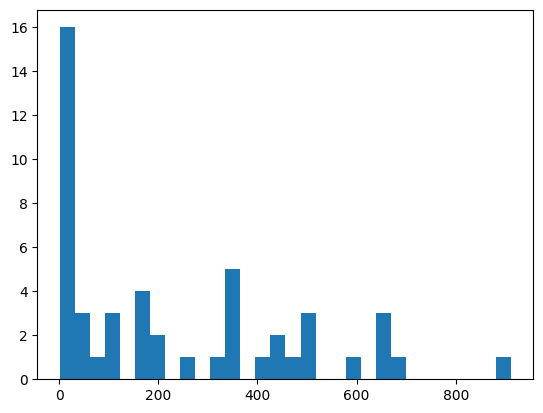

In [150]:

plt.hist(offense_merged['total_snaps'], bins=30)

In [151]:
college_nfl_merged = college_nfl_merged[college_nfl_merged['max_season'] > 2019]

In [152]:
full_merge = pd.merge(shrine_players, college_nfl_merged, on='college_gsis_id', how='inner')
print(full_merge.shape)
print(shrine_players.shape)
print(college_nfl_merged.shape)
full_merge.head(20)

(187, 97)
(338, 33)
(370, 65)


,college_gsis_id,first_name,last_name,football_name,weight,hand_size,last_twenty_of_forty_yd_dash,first_ten_of_forty_yd_dash,standing_broad_jump,three_cone,...,rushing_touchdowns_nfl,receiving_targets,receiving_receptions_nfl,receiving_yards_nfl,receiving_yards_per_route_run,receiving_touchdowns_nfl,receiving_yards_after_catch,defense_interceptions,defense_pass_breakups,played_in_nfl
0,350698,Dwight,McGlothern,Dwight,189.0,8.5,1.8699999,1.55,111.0,7.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1
1,362959,Jaden,Shirden,Jaden,189.0,9.25,1.8799999,1.56,117.0,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,324852,David,Ugwoegbu,David,243.0,10.25,1.97,1.75,116.0,7.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,330326,Jared,Harrison-Hunte,Jared,290.0,9.5,None,1.69,111.0,7.76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,351359,Robert,Longerbeam,Robert,174.0,8.5,None,1.5,134.0,6.76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5,373367,Trey,Taylor,Trey,206.0,9.25,1.96,1.59,123.0,6.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6,348991,Elijah,Roberts,Elijah,292.0,10.5,None,1.67,116.0,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
7,325610,Deantre,Prince,Deantre,184.0,8.625,1.8000002,1.55,125.0,7.46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1
8,309574,David,White,David,201.0,9.5,1.8899999,1.59,123.0,7.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
9,349410,Lideatrick,Griffin,Lideatrick,182.0,9.375,1.8499999,1.54,124.0,7.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [153]:
full_merge['acceleration_factor'] = full_merge['first_twenty_of_forty_yd_dash'].astype(float) - full_merge['last_twenty_of_forty_yd_dash'].astype(float)

In [154]:
# Rank performance within position groups as a percentile (note that lower is better for time based metrics)
position_groups = full_merge['position_college'].unique()
for position in position_groups:
    position_mask = full_merge['position_college'] == position
    full_merge.loc[position_mask, 'three_cone_percentile'] = full_merge[position_mask]['three_cone'].rank(pct=True, ascending=False)
    full_merge.loc[position_mask, 'weight_percentile'] = full_merge[position_mask]['weight'].rank(pct=True, ascending=True)
    full_merge.loc[position_mask, 'hand_size_percentile'] = full_merge[position_mask]['hand_size'].rank(pct=True, ascending=True)
    full_merge.loc[position_mask, 'forty_percentile'] = full_merge[position_mask]['forty_yd_dash'].rank(pct=True, ascending=False)
    full_merge.loc[position_mask, 'standing_broad_jump_percentile'] = full_merge[position_mask]['standing_broad_jump'].rank(pct=True, ascending=True)
    full_merge.loc[position_mask, 'height_percentile'] = full_merge[position_mask]['height'].rank(pct=True, ascending=True)
    full_merge.loc[position_mask, 'wingspan_percentile'] = full_merge[position_mask]['wingspan'].rank(pct=True, ascending=True)
    full_merge.loc[position_mask, 'vert_percentile'] = full_merge[position_mask]['standing_vertical'].rank(pct=True, ascending=True)
    full_merge.loc[position_mask, 'bench_percentile'] = full_merge[position_mask]['bench_reps_of_225'].rank(pct=True, ascending=True)
    full_merge.loc[position_mask, 'twenty_percentile'] = full_merge[position_mask]['twenty_yard_shuttle'].rank(pct=True, ascending=True)
    full_merge.loc[position_mask, 'arm_length_percentile'] = full_merge[position_mask]['arm_length'].rank(pct=True, ascending=True)
    full_merge.loc[position_mask, 'acceleration_factor_percentile'] = full_merge[position_mask]['acceleration_factor'].rank(pct=True, ascending=True)

In [155]:
full_merge.head(10)

,college_gsis_id,first_name,last_name,football_name,weight,hand_size,last_twenty_of_forty_yd_dash,first_ten_of_forty_yd_dash,standing_broad_jump,three_cone,...,hand_size_percentile,forty_percentile,standing_broad_jump_percentile,height_percentile,wingspan_percentile,vert_percentile,bench_percentile,twenty_percentile,arm_length_percentile,acceleration_factor_percentile
0,350698,Dwight,McGlothern,Dwight,189.0,8.5,1.8699999,1.55,111.0,7.23,...,0.232143,0.607143,0.074074,0.892857,0.196429,0.035714,NaN,0.629630,0.446429,0.560000
1,362959,Jaden,Shirden,Jaden,189.0,9.25,1.8799999,1.56,117.0,None,...,0.692308,0.807692,0.416667,0.115385,0.076923,0.416667,NaN,NaN,0.076923,0.454545
2,324852,David,Ugwoegbu,David,243.0,10.25,1.97,1.75,116.0,7.56,...,0.233333,0.230769,0.230769,0.600000,0.866667,0.115385,0.458333,1.000000,0.866667,0.777778
3,330326,Jared,Harrison-Hunte,Jared,290.0,9.5,None,1.69,111.0,7.76,...,0.659091,0.947368,0.638889,0.545455,0.454545,0.886364,NaN,0.275000,0.795455,NaN
4,351359,Robert,Longerbeam,Robert,174.0,8.5,None,1.5,134.0,6.76,...,0.232143,0.750000,1.000000,0.250000,0.678571,0.553571,NaN,0.296296,0.607143,NaN
5,373367,Trey,Taylor,Trey,206.0,9.25,1.96,1.59,123.0,6.9,...,0.529412,0.176471,0.500000,0.558824,0.470588,0.529412,0.966667,0.214286,0.647059,0.153846
6,348991,Elijah,Roberts,Elijah,292.0,10.5,None,1.67,116.0,None,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN
7,325610,Deantre,Prince,Deantre,184.0,8.625,1.8000002,1.55,125.0,7.46,...,0.339286,0.910714,0.722222,0.500000,0.285714,0.732143,0.352941,NaN,0.500000,0.800000
8,309574,David,White,David,201.0,9.5,1.8899999,1.59,123.0,7.05,...,0.807692,0.326923,0.519231,0.750000,0.461538,0.615385,0.357143,0.090909,0.634615,0.842105
9,349410,Lideatrick,Griffin,Lideatrick,182.0,9.375,1.8499999,1.54,124.0,7.04,...,0.750000,0.865385,0.653846,0.384615,0.307692,0.538462,NaN,0.613636,0.384615,0.473684


In [161]:
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
features = [
    'three_cone_percentile',
    'weight_percentile',
    'hand_size_percentile',
    'forty_percentile',
    'standing_broad_jump_percentile',
    'height_percentile',
    'wingspan_percentile',
    'vert_percentile',
    'bench_percentile',
    'twenty_percentile',
    'arm_length_percentile',
    'acceleration_factor_percentile',
]

X = full_merge[features]
y = full_merge['played_in_nfl']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(y_test.value_counts())

model.fit(X_train, y_train)

played_in_nfl
0    30
1     8
Name: count, dtype: int64


C:\Users\bps78\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:19:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [159]:
print(model.score(X_test, y_test))
importances = model.feature_importances_
pd.DataFrame({'Feature': model.feature_names_in_, 'Importance': importances}).sort_values(by='Importance', ascending=False)

0.7105263157894737


,Feature,Importance
2,hand_size_percentile,0.141303
7,vert_percentile,0.125608
5,height_percentile,0.096089
11,acceleration_factor_percentile,0.087452
10,arm_length_percentile,0.085315
9,twenty_percentile,0.079893
6,wingspan_percentile,0.076787
1,weight_percentile,0.067512
4,standing_broad_jump_percentile,0.065707
8,bench_percentile,0.062902


In [162]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred_proba = model.predict_proba(X_test)[:, 1]
top_k = int(0.2 * len(y_test))
top_preds = y_test.iloc[np.argsort(-y_pred_proba)[:top_k]]

print("Top 20% hit rate:", top_preds.mean())
print("Baseline hit rate:", y_test.mean())
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

Top 20% hit rate: 0.2857142857142857
Baseline hit rate: 0.21052631578947367
ROC AUC: 0.6


## TODO
#### Add in college production metrics to model to boost lift and ROC AUC
 - Age at draft
 - Peak usage share
 - Final-year usage share


#### Perform a model on those who DID play in the NFL to predict performance (e.g. snaps, yards, etc.) or how many snaps they played